In [1]:
!pip install medmnist

from medmnist import OCTMNIST
#dataset = OCTMNIST(split="test", download=True, size=64)

In [2]:
pip install medmnist torch torchvision torchinfo scikit-learn seaborn


Note: you may need to restart the kernel to use updated packages.


In [56]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from medmnist import OCTMNIST
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from torchinfo import summary
import time
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, 
                             confusion_matrix, roc_curve, auc)
from sklearn.preprocessing import label_binarize


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
train_dataset = OCTMNIST(split='train', transform=transform, download=True)
test_dataset  = OCTMNIST(split='test', transform=transform, download=True)

Using downloaded and verified file: C:\Users\vishn\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\vishn\.medmnist\octmnist.npz


In [6]:
print("train data :", len(train_dataset))
print("test data :", len(test_dataset))

train data : 97477
test data : 1000


In [7]:
train_labels = np.array(train_dataset.labels).squeeze()
print("Unique class in train data:", np.unique(train_labels))
print("Class distribution in train data:", Counter(train_labels))

Unique class in train data: [0 1 2 3]
Class distribution in train data: Counter({3: 46026, 0: 33484, 1: 10213, 2: 7754})


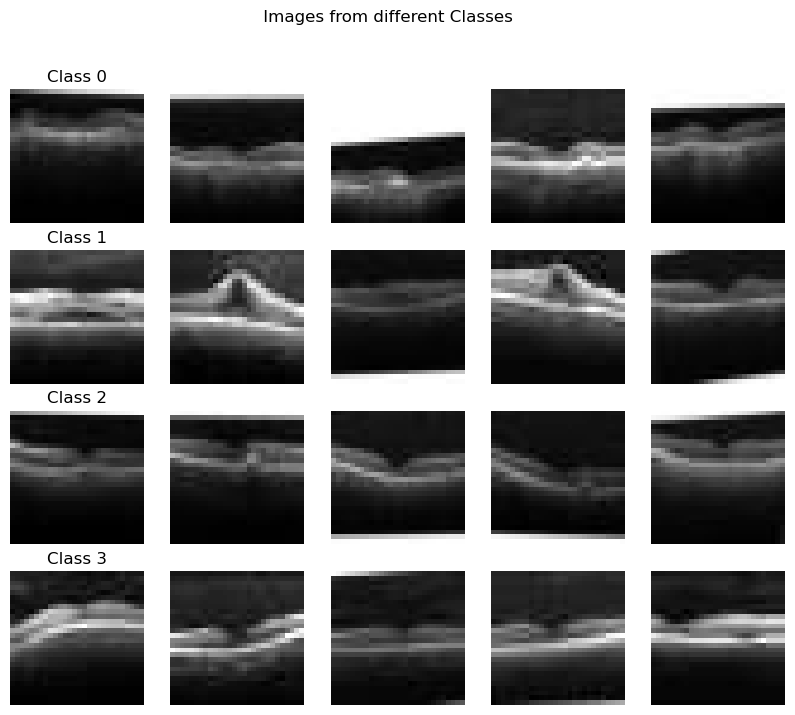

In [8]:
def plot_samples_by_class(dataset, num_samples=5):
    classes = np.unique(np.array(dataset.labels).squeeze())
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(num_samples*2, len(classes)*2))
    for i, cls in enumerate(classes):
        indices = np.where(np.array(dataset.labels).squeeze() == cls)[0]
        sample_indices = np.random.choice(indices, num_samples, replace=False)
        for j, idx in enumerate(sample_indices):
            img, label = dataset[idx]
            ax = axes[i, j] if len(classes) > 1 else axes[j]
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
            if j == 0:
                ax.set_title(f"Class {cls}")
    plt.suptitle(" Images from different Classes")
    plt.show()

plot_samples_by_class(train_dataset)

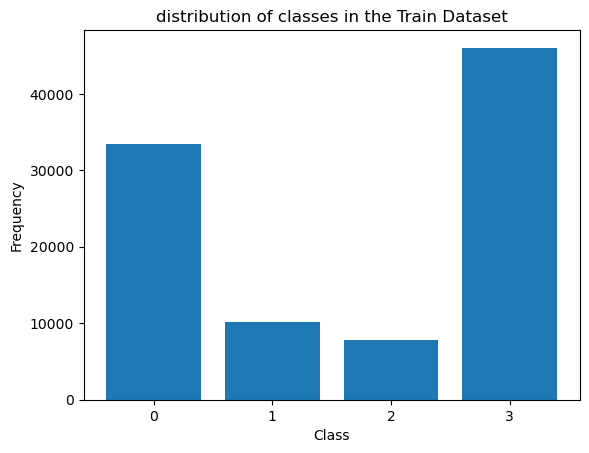

In [9]:
plt.figure()
plt.hist(train_labels, bins=np.arange(5)-0.5, rwidth=0.8)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("distribution of classes in the Train Dataset")
plt.xticks(np.unique(train_labels))
plt.show()

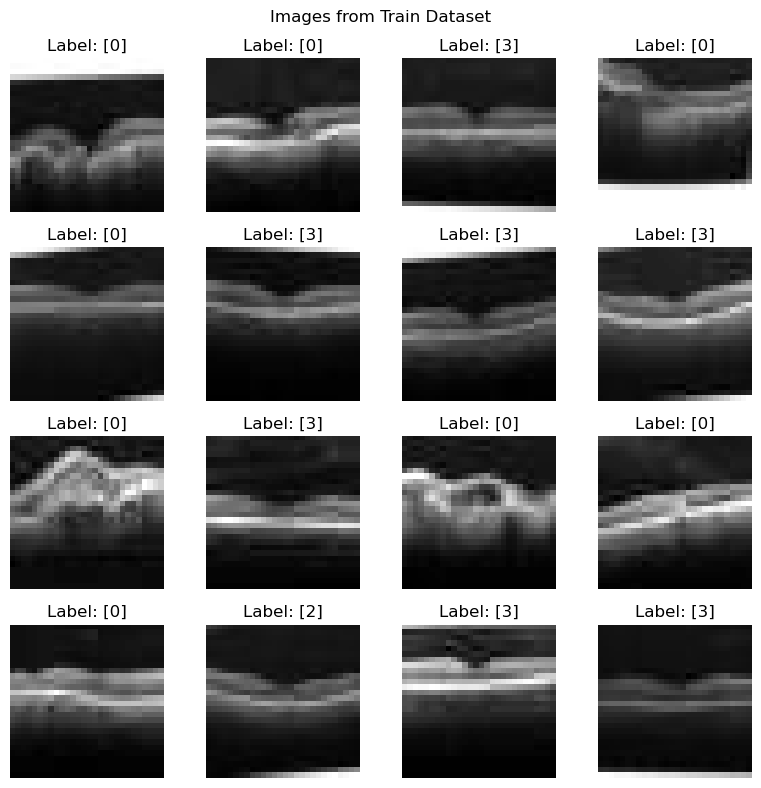

In [10]:
def plot_random_images(dataset, num_images=16):
    indices = np.random.choice(len(dataset), num_images, replace=False)
    plt.figure(figsize=(8,8))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        plt.subplot(4, 4, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle("Images from Train Dataset")
    plt.tight_layout()
    plt.show()

plot_random_images(train_dataset)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_images_per_class(dataset):

    all_labels = np.array(dataset.labels).squeeze()
    classes = np.unique(all_labels)
    
    mean_images = {}
    for cls in classes:
        indices = np.where(all_labels == cls)[0]
        imgs = [dataset[i][0].numpy() for i in indices]
        imgs = np.stack(imgs, axis=0)  
        mean_image = np.mean(imgs, axis=0)  
        mean_images[cls] = mean_image.squeeze()  

    n_classes = len(classes)
    plt.figure(figsize=(12, 3))
    for i, cls in enumerate(classes):
        plt.subplot(1, n_classes, i + 1)
        plt.imshow(mean_images[cls], cmap='gray')
        plt.title(f"Class {cls}")
        plt.axis('off')
    plt.suptitle("Mean Image per Class")
    plt.show()


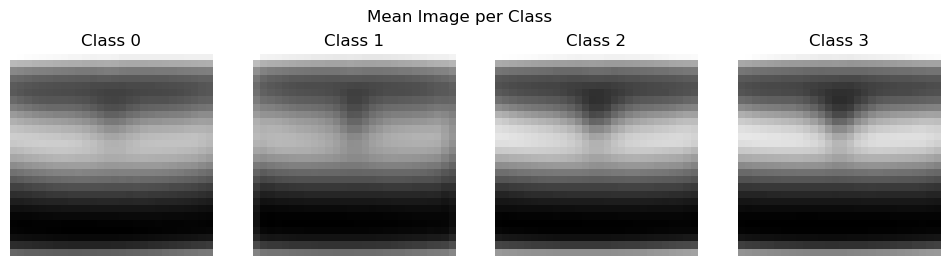

In [12]:
plot_mean_images_per_class(train_dataset)

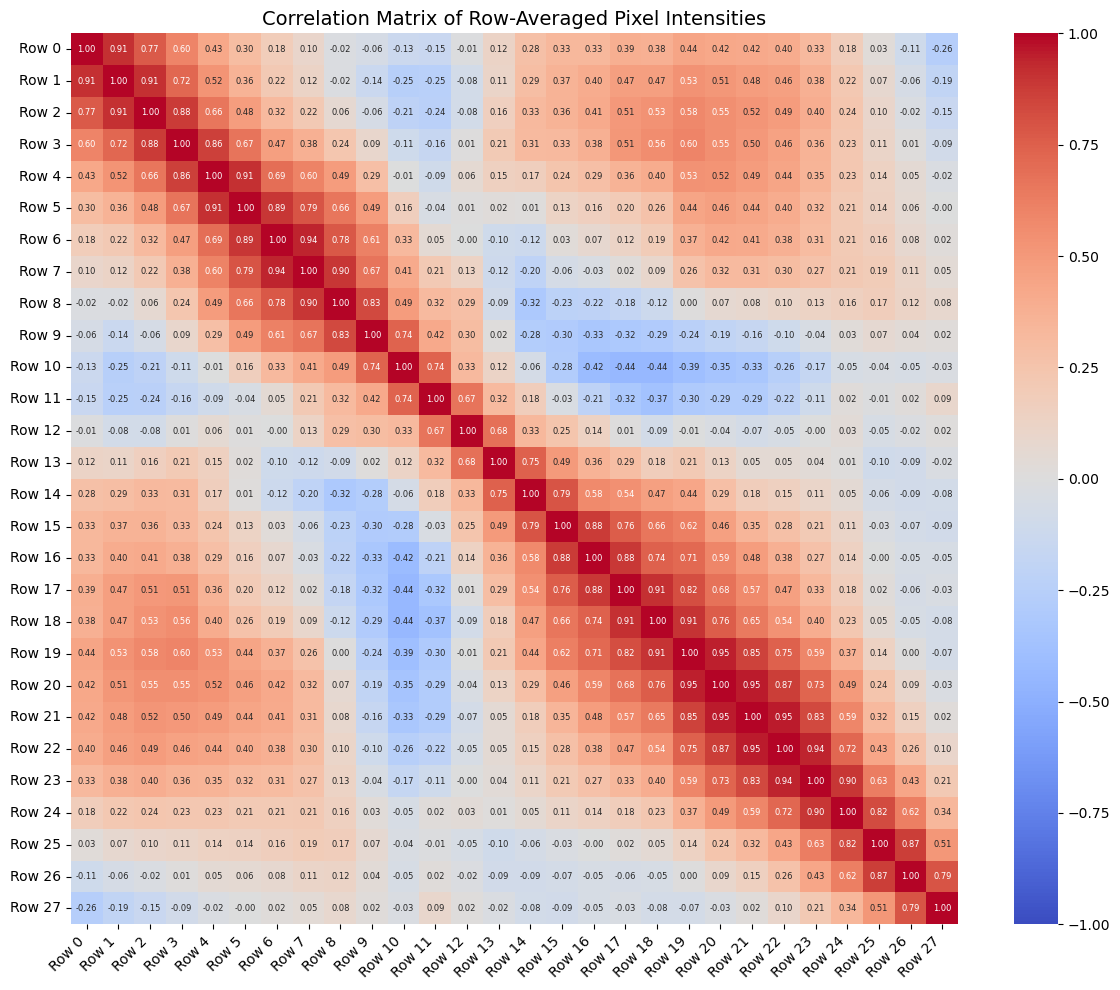

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_row_intensity_correlation(dataset, num_samples=100):
   
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    row_intensities = []
    for idx in indices:
        img, _ = dataset[idx]  
        img_np = img.squeeze().numpy()  
        row_avg = np.mean(img_np, axis=1)  
        row_intensities.append(row_avg)
    
    row_intensities = np.array(row_intensities)  
   
    corr_matrix = np.corrcoef(row_intensities, rowvar=False)

   
    plt.figure(figsize=(12, 10)) 
    sns.heatmap(
        corr_matrix,
        annot=True,         
        fmt=".2f",          
        cmap="coolwarm",   
        xticklabels=[f"Row {i}" for i in range(28)],
        yticklabels=[f"Row {i}" for i in range(28)],
        annot_kws={"size": 6},  
        vmin=-1, vmax=1
    )
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)               
    plt.title("Correlation Matrix of Row-Averaged Pixel Intensities", fontsize=14)
    plt.tight_layout()
    plt.show()
plot_row_intensity_correlation(train_dataset, num_samples=100)


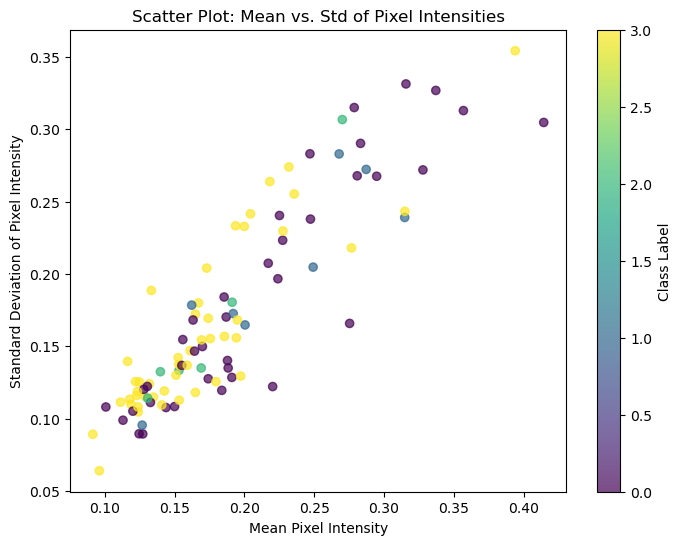

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_std_scatter(dataset, num_samples=100):
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    means = []
    stds = []
    labels = []
    
    for idx in indices:
        img, label = dataset[idx]
        img_np = img.squeeze().numpy()
        means.append(np.mean(img_np))
        stds.append(np.std(img_np))
        labels.append(label)
    
    means = np.array(means)
    stds = np.array(stds)
    labels = np.array(labels)
    
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(means, stds, c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label="Class Label")
    plt.xlabel("Mean Pixel Intensity")
    plt.ylabel("Standard Deviation of Pixel Intensity")
    plt.title("Scatter Plot: Mean vs. Std of Pixel Intensities")
    plt.show()


plot_mean_std_scatter(train_dataset, num_samples=100)


In [13]:
from sklearn.model_selection import train_test_split
train_indices, val_indices = train_test_split(
    np.arange(len(train_dataset)),
    test_size=0.2,
    random_state=42,
    stratify=train_labels
)

train_subset = Subset(train_dataset, train_indices)
val_subset   = Subset(train_dataset, val_indices)


In [14]:
train_labels_subset = np.array(train_dataset.labels)[train_indices].squeeze()

In [15]:
class_counts = np.bincount(train_labels_subset)
print("Class counts in train_subset:", class_counts)


Class counts in train_subset: [26787  8170  6203 36821]


In [16]:
class_weights = 1.0 / class_counts
print("Class weights:", class_weights)

Class weights: [3.73315414e-05 1.22399021e-04 1.61212317e-04 2.71584150e-05]


In [17]:
sample_weights = [class_weights[label] for label in train_labels_subset]
sample_weights = torch.FloatTensor(sample_weights)


In [18]:
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [19]:
batch_size = 64

In [20]:
train_loader = DataLoader(
    train_subset, 
    batch_size=batch_size, 
    sampler=sampler
)

In [33]:
val_loader = DataLoader(
    val_subset, 
    batch_size=batch_size, 
    shuffle=False
)

In [21]:
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

In [41]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) 
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 7 * 7, 128)  
        self.fc2 = nn.Linear(128, 4)             

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x) 
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  
        return x


In [42]:
model = CNN().to(device)
print("Model Summary:")
summary(model, input_size=(batch_size, 1, 28, 28))

Model Summary:


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Conv2d: 1-1                            [64, 32, 28, 28]          320
├─Conv2d: 1-2                            [64, 64, 28, 28]          18,496
├─MaxPool2d: 1-3                         [64, 64, 14, 14]          --
├─Conv2d: 1-4                            [64, 128, 14, 14]         73,856
├─MaxPool2d: 1-5                         [64, 128, 7, 7]           --
├─Dropout: 1-6                           [64, 128, 7, 7]           --
├─Linear: 1-7                            [64, 128]                 802,944
├─Dropout: 1-8                           [64, 128]                 --
├─Linear: 1-9                            [64, 4]                   516
Total params: 896,132
Trainable params: 896,132
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.92
Input size (MB): 0.20
Forward/backward pass size (MB): 51.45
Params size (MB): 3.58
Estimated Tota

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [44]:
num_epochs = 25
best_val_loss = np.inf

In [45]:
train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).long().squeeze()
        optimizer.zero_grad()      
        outputs = model(images)     
        loss = criterion(outputs, labels)
        loss.backward()             
        optimizer.step()            
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).long().squeeze()
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss = val_running_loss / val_total
    val_acc  = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {epoch_loss:.4f}  Train Acc: {epoch_acc:.4f}  Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.4f}")

total_training_time = time.time() - start_time
print("Total Training Time: {:.2f} seconds".format(total_training_time))

Epoch 1/25  Train Loss: 0.8935  Train Acc: 0.6114  Val Loss: 0.6621  Val Acc: 0.7184
Epoch 2/25  Train Loss: 0.5903  Train Acc: 0.7668  Val Loss: 0.5307  Val Acc: 0.7963
Epoch 3/25  Train Loss: 0.5224  Train Acc: 0.7928  Val Loss: 0.4349  Val Acc: 0.8326
Epoch 4/25  Train Loss: 0.4745  Train Acc: 0.8131  Val Loss: 0.4322  Val Acc: 0.8253
Epoch 5/25  Train Loss: 0.4249  Train Acc: 0.8328  Val Loss: 0.3830  Val Acc: 0.8548
Epoch 6/25  Train Loss: 0.3939  Train Acc: 0.8471  Val Loss: 0.3966  Val Acc: 0.8470
Epoch 7/25  Train Loss: 0.3602  Train Acc: 0.8584  Val Loss: 0.3683  Val Acc: 0.8611
Epoch 8/25  Train Loss: 0.3345  Train Acc: 0.8711  Val Loss: 0.3664  Val Acc: 0.8575
Epoch 9/25  Train Loss: 0.3141  Train Acc: 0.8797  Val Loss: 0.3142  Val Acc: 0.8841
Epoch 10/25  Train Loss: 0.2918  Train Acc: 0.8876  Val Loss: 0.3236  Val Acc: 0.8814
Epoch 11/25  Train Loss: 0.2742  Train Acc: 0.8933  Val Loss: 0.3166  Val Acc: 0.8847
Epoch 12/25  Train Loss: 0.2615  Train Acc: 0.8993  Val Loss: 0

In [46]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_labels_all = []
test_preds_all  = []
test_running_loss = 0.0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).long().squeeze()
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_labels_all.extend(labels.cpu().numpy())
        test_preds_all.extend(predicted.cpu().numpy())

test_loss = test_running_loss / test_total
test_acc  = accuracy_score(test_labels_all, test_preds_all)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels_all, test_preds_all, average='weighted')

print("Test Loss: {:.4f}".format(test_loss))
print("Test Accuracy: {:.4f}".format(test_acc))
print("Precision: {:.4f}  Recall: {:.4f}  F1 Score: {:.4f}".format(precision, recall, f1))


C:\Users\vishn\AppData\Local\Temp\ipykernel_34096\3161871993.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.8742
Test Accuracy: 0.7570
Precision: 0.7812  Recall: 0.7570  F1 Score: 0.7429


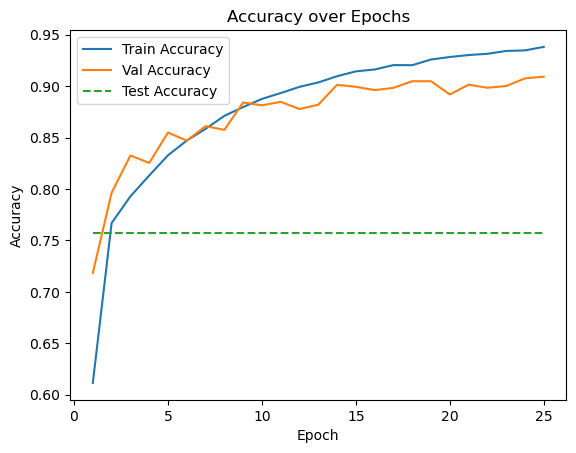

In [48]:
epochs_range = range(1, num_epochs + 1)
plt.figure()
plt.plot(epochs_range, train_accs, label='Train Accuracy')
plt.plot(epochs_range, val_accs, label='Val Accuracy')
plt.plot(epochs_range, [test_acc]*num_epochs, label='Test Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

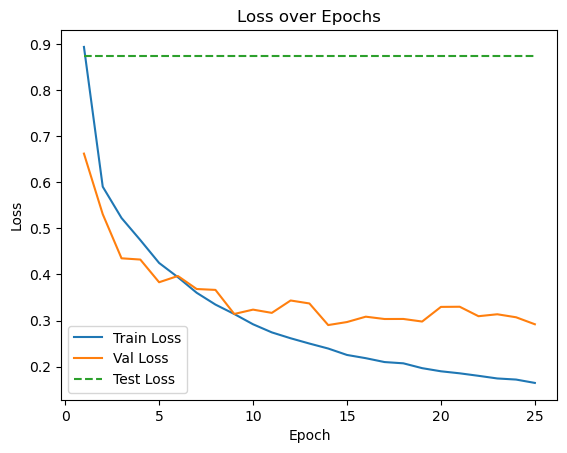

In [49]:
plt.figure()
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.plot(epochs_range, [test_loss]*num_epochs, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

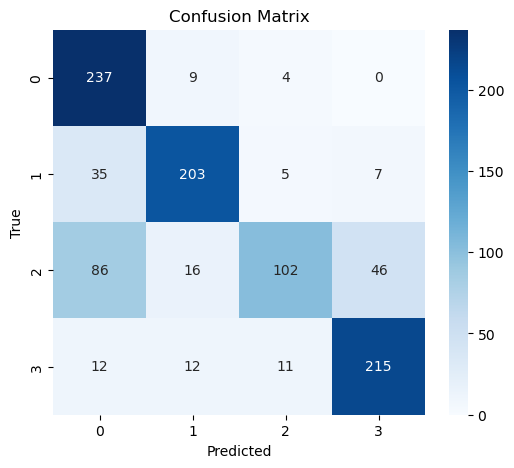

In [50]:
cm = confusion_matrix(test_labels_all, test_preds_all)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

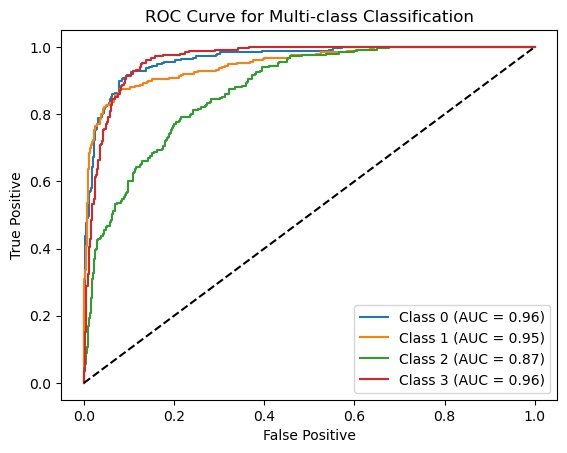

In [51]:
n_classes = 4
test_labels_bin = label_binarize(test_labels_all, classes=[0,1,2,3])
all_probs = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
all_probs = np.array(all_probs)

plt.figure()
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_labels_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc='lower right')
plt.show()

In [57]:
class CNN_new(nn.Module):
    def __init__(self):
        super(CNN_new, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 4)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [58]:
def train_and_evaluate(model, criterion, optimizer, num_epochs, train_loader, val_loader, test_loader,
                       scheduler=None, early_stopping_patience=None):
    best_val_loss = float('inf')
    epochs_since_improvement = 0
    train_losses, val_losses, test_losses = [], [], []
    train_accs, val_accs, test_accs = [], [], []
    best_model_state = None
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).long().squeeze()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).long().squeeze()
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss = running_loss / total
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device).long().squeeze()
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_loss = running_loss / total
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        if scheduler is not None:
            scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1
            if early_stopping_patience is not None and epochs_since_improvement >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
    return train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, best_model_state


In [59]:
num_epochs_comp = 20

In [60]:
base_model = CNN().to(device)
criterion_ce = nn.CrossEntropyLoss()
optimizer_base = optim.Adam(base_model.parameters(), lr=0.001)
print("\nTraining base model with CrossEntropyLoss...")
base_train_losses, base_val_losses, base_test_losses, base_train_accs, base_val_accs, base_test_accs, base_best_state = \
    train_and_evaluate(base_model, criterion_ce, optimizer_base, num_epochs_comp, train_loader, val_loader, test_loader)



Training base model with CrossEntropyLoss...
Epoch 1/20: Train Loss: 0.8759 | Train Acc: 0.6182 | Val Loss: 0.5779 | Val Acc: 0.7820 | Test Loss: 0.6385 | Test Acc: 0.7290
Epoch 2/20: Train Loss: 0.5881 | Train Acc: 0.7657 | Val Loss: 0.4505 | Val Acc: 0.8360 | Test Loss: 0.6263 | Test Acc: 0.7470
Epoch 3/20: Train Loss: 0.5263 | Train Acc: 0.7924 | Val Loss: 0.4586 | Val Acc: 0.8129 | Test Loss: 0.6863 | Test Acc: 0.7220
Epoch 4/20: Train Loss: 0.4813 | Train Acc: 0.8102 | Val Loss: 0.5004 | Val Acc: 0.7859 | Test Loss: 0.7621 | Test Acc: 0.7110
Epoch 5/20: Train Loss: 0.4370 | Train Acc: 0.8287 | Val Loss: 0.4519 | Val Acc: 0.8171 | Test Loss: 0.6420 | Test Acc: 0.7520
Epoch 6/20: Train Loss: 0.4012 | Train Acc: 0.8434 | Val Loss: 0.4037 | Val Acc: 0.8378 | Test Loss: 0.5649 | Test Acc: 0.7870
Epoch 7/20: Train Loss: 0.3711 | Train Acc: 0.8556 | Val Loss: 0.3667 | Val Acc: 0.8582 | Test Loss: 0.6373 | Test Acc: 0.7710
Epoch 8/20: Train Loss: 0.3518 | Train Acc: 0.8622 | Val Loss: 0.

In [62]:
nll_model = CNN_new().to(device)
criterion_nll = nn.NLLLoss()
optimizer_nll = optim.Adam(nll_model.parameters(), lr=0.001)
print("\nTraining model with NLLLoss...")
nll_train_losses, nll_val_losses, nll_test_losses, nll_train_accs, nll_val_accs, nll_test_accs, nll_best_state = \
    train_and_evaluate(nll_model, criterion_nll, optimizer_nll, num_epochs_comp, train_loader, val_loader, test_loader)



Training model with NLLLoss...
Epoch 1/20: Train Loss: 0.8707 | Train Acc: 0.6243 | Val Loss: 0.5898 | Val Acc: 0.7563 | Test Loss: 0.6275 | Test Acc: 0.7660
Epoch 2/20: Train Loss: 0.5930 | Train Acc: 0.7624 | Val Loss: 0.5150 | Val Acc: 0.7994 | Test Loss: 0.6056 | Test Acc: 0.7690
Epoch 3/20: Train Loss: 0.5163 | Train Acc: 0.7959 | Val Loss: 0.4418 | Val Acc: 0.8199 | Test Loss: 0.6503 | Test Acc: 0.7500
Epoch 4/20: Train Loss: 0.4546 | Train Acc: 0.8234 | Val Loss: 0.4143 | Val Acc: 0.8345 | Test Loss: 0.6596 | Test Acc: 0.7600
Epoch 5/20: Train Loss: 0.4090 | Train Acc: 0.8411 | Val Loss: 0.3915 | Val Acc: 0.8492 | Test Loss: 0.5583 | Test Acc: 0.8120
Epoch 6/20: Train Loss: 0.3660 | Train Acc: 0.8577 | Val Loss: 0.3932 | Val Acc: 0.8504 | Test Loss: 0.5288 | Test Acc: 0.8080
Epoch 7/20: Train Loss: 0.3384 | Train Acc: 0.8702 | Val Loss: 0.3670 | Val Acc: 0.8580 | Test Loss: 0.5386 | Test Acc: 0.8150
Epoch 8/20: Train Loss: 0.3200 | Train Acc: 0.8758 | Val Loss: 0.3457 | Val Acc

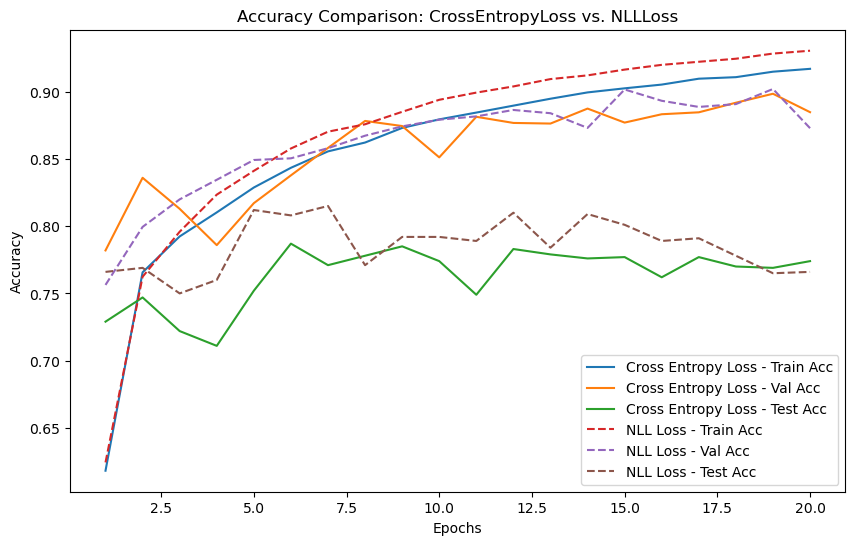

In [63]:
epochs_range_comp = range(1, len(base_train_accs)+1)
plt.figure(figsize=(10,6))
plt.plot(epochs_range_comp, base_train_accs, label="Cross Entropy Loss - Train Acc")
plt.plot(epochs_range_comp, base_val_accs, label="Cross Entropy Loss - Val Acc")
plt.plot(epochs_range_comp, base_test_accs, label="Cross Entropy Loss - Test Acc")
plt.plot(epochs_range_comp, nll_train_accs, label="NLL Loss - Train Acc", linestyle="--")
plt.plot(epochs_range_comp, nll_val_accs, label="NLL Loss - Val Acc", linestyle="--")
plt.plot(epochs_range_comp, nll_test_accs, label="NLL Loss - Test Acc", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: CrossEntropyLoss vs. NLLLoss")
plt.legend()
plt.show()

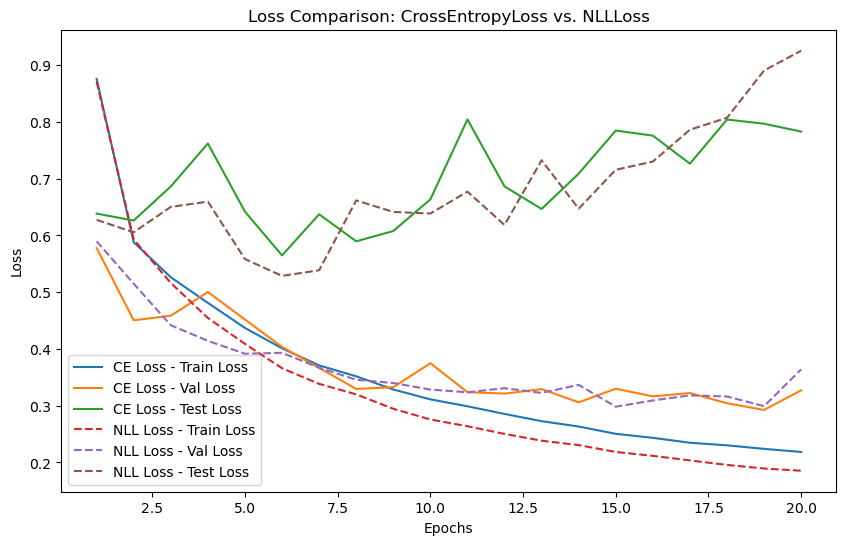

In [64]:
plt.figure(figsize=(10,6))
plt.plot(epochs_range_comp, base_train_losses, label="CE Loss - Train Loss")
plt.plot(epochs_range_comp, base_val_losses, label="CE Loss - Val Loss")
plt.plot(epochs_range_comp, base_test_losses, label="CE Loss - Test Loss")
plt.plot(epochs_range_comp, nll_train_losses, label="NLL Loss - Train Loss", linestyle="--")
plt.plot(epochs_range_comp, nll_val_losses, label="NLL Loss - Val Loss", linestyle="--")
plt.plot(epochs_range_comp, nll_test_losses, label="NLL Loss - Test Loss", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison: CrossEntropyLoss vs. NLLLoss")
plt.legend()
plt.show()

In [142]:
class CNN_NLL_BN(nn.Module):
    def __init__(self):
        super(CNN_NLL_BN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 4)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return F.log_softmax(self.fc2(x), dim=1)

In [143]:
modelA = CNN_NLL_BN().to(device)
criterionA = nn.NLLLoss()
optimizerA = optim.Adam(modelA.parameters(), lr=0.001)

print("\n=== Step 9 - Model A: BN-only + NLLLoss ===")
(trainA_losses, valA_losses, testA_losses,
 trainA_acc, valA_acc, testA_acc,
 bestA_state) = train_and_evaluate(
    modelA,
    criterionA,
    optimizerA,
    num_epochs=20,
    train_loader=train_loader,   
    val_loader=val_loader,
    test_loader=test_loader
)



=== Step 9 - Model A: BN-only + NLLLoss ===
Epoch 1/20: Train Loss: 0.7947 | Train Acc: 0.6665 | Val Loss: 0.5486 | Val Acc: 0.7871 | Test Loss: 0.6693 | Test Acc: 0.7270
Epoch 2/20: Train Loss: 0.5824 | Train Acc: 0.7687 | Val Loss: 0.4894 | Val Acc: 0.8092 | Test Loss: 0.5389 | Test Acc: 0.7850
Epoch 3/20: Train Loss: 0.5187 | Train Acc: 0.7964 | Val Loss: 0.4582 | Val Acc: 0.8303 | Test Loss: 0.8292 | Test Acc: 0.6990
Epoch 4/20: Train Loss: 0.4728 | Train Acc: 0.8157 | Val Loss: 0.3748 | Val Acc: 0.8629 | Test Loss: 0.4844 | Test Acc: 0.8270
Epoch 5/20: Train Loss: 0.4327 | Train Acc: 0.8328 | Val Loss: 0.3884 | Val Acc: 0.8692 | Test Loss: 0.8558 | Test Acc: 0.7300
Epoch 6/20: Train Loss: 0.4032 | Train Acc: 0.8437 | Val Loss: 0.2944 | Val Acc: 0.8970 | Test Loss: 0.7026 | Test Acc: 0.7610
Epoch 7/20: Train Loss: 0.3815 | Train Acc: 0.8515 | Val Loss: 0.3718 | Val Acc: 0.8666 | Test Loss: 0.7663 | Test Acc: 0.7640
Epoch 8/20: Train Loss: 0.3610 | Train Acc: 0.8599 | Val Loss: 0.2

In [144]:
augment_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [145]:
train_dataset_aug = OCTMNIST(split='train', transform=augment_transform, download=True)
train_subset_aug  = Subset(train_dataset_aug, train_indices)

Using downloaded and verified file: C:\Users\vishn\.medmnist\octmnist.npz


In [146]:
train_labels_subset_aug = np.array(train_dataset_aug.labels)[train_indices].squeeze()
class_counts_aug = np.bincount(train_labels_subset_aug)
class_weights_aug = 1.0 / class_counts_aug
sample_weights_aug = torch.FloatTensor([class_weights_aug[l] for l in train_labels_subset_aug])
sampler_aug = WeightedRandomSampler(
    weights=sample_weights_aug,
    num_samples=len(sample_weights_aug),
    replacement=True
)
train_loader_aug = DataLoader(train_subset_aug, batch_size=batch_size, sampler=sampler_aug)


In [147]:
class CNN_NLL_Aug(nn.Module):
    def __init__(self):
        super(CNN_NLL_Aug, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 4)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return F.log_softmax(self.fc2(x), dim=1)


In [148]:
modelB = CNN_NLL_Aug().to(device)
criterionB = nn.NLLLoss()
optimizerB = optim.Adam(modelB.parameters(), lr=0.001)

print("\n=== Step 9 - Model B: DataAug-only + NLLLoss ===")
(trainB_losses, valB_losses, testB_losses,
 trainB_acc, valB_acc, testB_acc,
 bestB_state) = train_and_evaluate(
    modelB,
    criterionB,
    optimizerB,
    num_epochs=20,
    train_loader=train_loader_aug,  
    val_loader=val_loader,
    test_loader=test_loader
)



=== Step 9 - Model B: DataAug-only + NLLLoss ===
Epoch 1/20: Train Loss: 0.9407 | Train Acc: 0.5893 | Val Loss: 0.6608 | Val Acc: 0.7143 | Test Loss: 0.7280 | Test Acc: 0.7070
Epoch 2/20: Train Loss: 0.7067 | Train Acc: 0.7153 | Val Loss: 0.5414 | Val Acc: 0.7887 | Test Loss: 0.7006 | Test Acc: 0.7390
Epoch 3/20: Train Loss: 0.6470 | Train Acc: 0.7403 | Val Loss: 0.5000 | Val Acc: 0.8051 | Test Loss: 0.6066 | Test Acc: 0.7530
Epoch 4/20: Train Loss: 0.6143 | Train Acc: 0.7536 | Val Loss: 0.5425 | Val Acc: 0.7692 | Test Loss: 0.6641 | Test Acc: 0.7430
Epoch 5/20: Train Loss: 0.5751 | Train Acc: 0.7693 | Val Loss: 0.4838 | Val Acc: 0.8123 | Test Loss: 0.5799 | Test Acc: 0.7800
Epoch 6/20: Train Loss: 0.5613 | Train Acc: 0.7746 | Val Loss: 0.4522 | Val Acc: 0.8247 | Test Loss: 0.5700 | Test Acc: 0.7820
Epoch 7/20: Train Loss: 0.5379 | Train Acc: 0.7871 | Val Loss: 0.4518 | Val Acc: 0.8237 | Test Loss: 0.5809 | Test Acc: 0.7680
Epoch 8/20: Train Loss: 0.5240 | Train Acc: 0.7915 | Val Loss

In [149]:
augment_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [150]:
train_dataset_augC = OCTMNIST(split='train', transform=augment_transform, download=True)
train_subset_augC  = Subset(train_dataset_augC, train_indices)

train_labels_subset_augC = np.array(train_dataset_augC.labels)[train_indices].squeeze()
class_counts_augC = np.bincount(train_labels_subset_augC)
class_weights_augC = 1.0 / class_counts_augC
sample_weights_augC = torch.FloatTensor([class_weights_augC[l] for l in train_labels_subset_augC])
sampler_augC = WeightedRandomSampler(
    weights=sample_weights_augC,
    num_samples=len(sample_weights_augC),
    replacement=True
)
train_loader_augC = DataLoader(train_subset_augC, batch_size=batch_size, sampler=sampler_augC)


Using downloaded and verified file: C:\Users\vishn\.medmnist\octmnist.npz


In [151]:
class CNN_NLL_Advanced(nn.Module):
    def __init__(self):
        super(CNN_NLL_Advanced, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.bn_fc = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 4)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout(x)
        return F.log_softmax(self.fc2(x), dim=1)


In [152]:
modelC = CNN_NLL_Advanced().to(device)
criterionC = nn.NLLLoss()
optimizerC = optim.Adam(modelC.parameters(), lr=0.001, weight_decay=1e-4)
schedulerC = ReduceLROnPlateau(optimizerC, mode='min', factor=0.5, patience=3, verbose=True)


C:\Users\vishn\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [153]:
def train_and_evaluate_with_threshold(model, criterion, optimizer, num_epochs, train_loader, val_loader, test_loader,
                                        scheduler=None, early_stopping_patience=None, test_acc_threshold=None):
    best_val_loss = float('inf')
    epochs_since_improvement = 0
    train_losses, val_losses, test_losses = [], [], []
    train_accs, val_accs, test_accs = [], [], []
    best_model_state = None
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).long().squeeze()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).long().squeeze()
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss = running_loss / total
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device).long().squeeze()
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_loss = running_loss / total
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        if scheduler is not None:
            scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1
            if early_stopping_patience is not None and epochs_since_improvement >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1} (based on validation loss)")
                break

        if test_acc_threshold is not None and test_acc >= test_acc_threshold:
            print(f"Test accuracy reached {test_acc:.4f} (threshold {test_acc_threshold}), stopping training early.")
            best_model_state = model.state_dict()  
            break
        
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
    return train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, best_model_state

In [154]:
print("\n=== Step 9 - Model C: BN + DataAug + LR Scheduler + EarlyStopping ===")

test_acc_threshold = 0.85

(trainC_losses, valC_losses, testC_losses,
 trainC_acc, valC_acc, testC_acc,
 bestC_state) = train_and_evaluate_with_threshold(
    modelC,
    criterionC,
    optimizerC,
    num_epochs=15,
    train_loader=train_loader_augC,
    val_loader=val_loader,
    test_loader=test_loader,
    scheduler=schedulerC,
    early_stopping_patience=8,
    test_acc_threshold=test_acc_threshold
)



=== Step 9 - Model C: BN + DataAug + LR Scheduler + EarlyStopping ===
Epoch 1/15: Train Loss: 0.7270 | Train Acc: 0.7023 | Val Loss: 0.5549 | Val Acc: 0.7690 | Test Loss: 0.6594 | Test Acc: 0.7490
Epoch 2/15: Train Loss: 0.5803 | Train Acc: 0.7696 | Val Loss: 0.4048 | Val Acc: 0.8564 | Test Loss: 0.6806 | Test Acc: 0.7290
Epoch 3/15: Train Loss: 0.5271 | Train Acc: 0.7916 | Val Loss: 0.5230 | Val Acc: 0.7865 | Test Loss: 0.7012 | Test Acc: 0.7270
Epoch 4/15: Train Loss: 0.5011 | Train Acc: 0.8017 | Val Loss: 0.3772 | Val Acc: 0.8661 | Test Loss: 0.5802 | Test Acc: 0.7830
Epoch 5/15: Train Loss: 0.4778 | Train Acc: 0.8115 | Val Loss: 0.3865 | Val Acc: 0.8518 | Test Loss: 0.6498 | Test Acc: 0.7500
Epoch 6/15: Train Loss: 0.4576 | Train Acc: 0.8212 | Val Loss: 0.4138 | Val Acc: 0.8362 | Test Loss: 0.5036 | Test Acc: 0.8100
Epoch 7/15: Train Loss: 0.4445 | Train Acc: 0.8268 | Val Loss: 0.3156 | Val Acc: 0.8878 | Test Loss: 0.4688 | Test Acc: 0.8180
Epoch 8/15: Train Loss: 0.4305 | Train A

In [155]:
print("\nFinal Test Accuracies:")
print(f"Model A (BN-only): {testA_acc[-1]:.4f}")
print(f"Model B (DataAug-only): {testB_acc[-1]:.4f}")
print(f"Model C (BN+Aug+Scheduler): {testC_acc[-1]:.4f}")


Final Test Accuracies:
Model A (BN-only): 0.8050
Model B (DataAug-only): 0.7950
Model C (BN+Aug+Scheduler): 0.8210


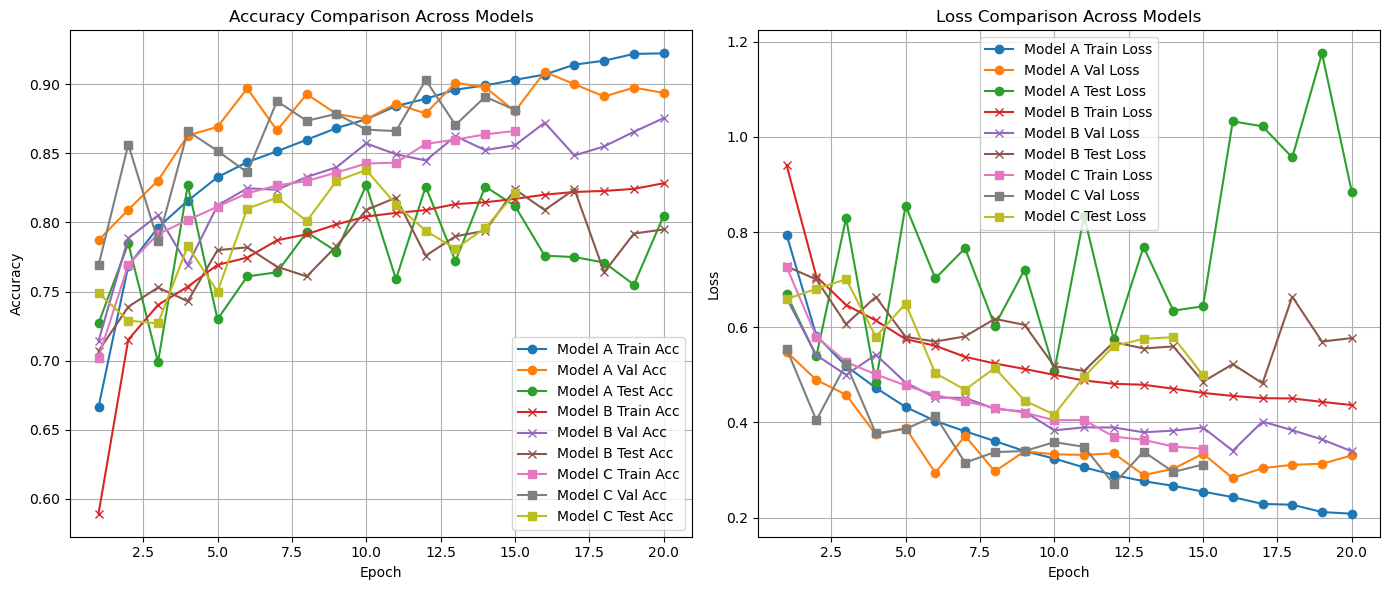

In [160]:
import matplotlib.pyplot as plt
epochs_A = range(1, len(trainA_acc) + 1)  
epochs_B = range(1, len(trainB_acc) + 1)  
epochs_C = range(1, len(trainC_acc) + 1)  

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_A, trainA_acc, label="Model A Train Acc", marker="o")
plt.plot(epochs_A, valA_acc, label="Model A Val Acc", marker="o")
plt.plot(epochs_A, testA_acc, label="Model A Test Acc", marker="o")

plt.plot(epochs_B, trainB_acc, label="Model B Train Acc", marker="x")
plt.plot(epochs_B, valB_acc, label="Model B Val Acc", marker="x")
plt.plot(epochs_B, testB_acc, label="Model B Test Acc", marker="x")

plt.plot(epochs_C, trainC_acc, label="Model C Train Acc", marker="s")
plt.plot(epochs_C, valC_acc, label="Model C Val Acc", marker="s")
plt.plot(epochs_C, testC_acc, label="Model C Test Acc", marker="s")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Across Models")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_A, trainA_losses, label="Model A Train Loss", marker="o")
plt.plot(epochs_A, valA_losses, label="Model A Val Loss", marker="o")
plt.plot(epochs_A, testA_losses, label="Model A Test Loss", marker="o")

plt.plot(epochs_B, trainB_losses, label="Model B Train Loss", marker="x")
plt.plot(epochs_B, valB_losses, label="Model B Val Loss", marker="x")
plt.plot(epochs_B, testB_losses, label="Model B Test Loss", marker="x")

plt.plot(epochs_C, trainC_losses, label="Model C Train Loss", marker="s")
plt.plot(epochs_C, valC_losses, label="Model C Val Loss", marker="s")
plt.plot(epochs_C, testC_losses, label="Model C Test Loss", marker="s")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Comparison Across Models")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


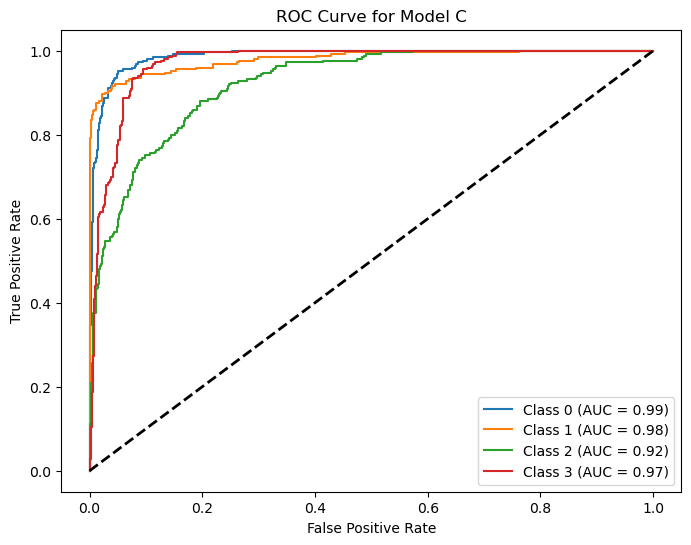

In [163]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

modelC.eval()


all_true = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = modelC(images)  
        probs = torch.exp(outputs)  
        all_probs.extend(probs.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

all_true = np.array(all_true)
all_probs = np.array(all_probs)

n_classes = 4
all_true_bin = label_binarize(all_true, classes=[0, 1, 2, 3])

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model C')
plt.legend(loc='lower right')
plt.show()


In [166]:
torch.save(bestC_state, 'best_model_C.pth')
print("Best model weights for Model C have been saved to 'best_model_C.pth'")
modelC.load_state_dict(torch.load('best_model_C.pth'))
modelC.eval()



Best model weights for Model C have been saved to 'best_model_C.pth'


C:\Users\vishn\AppData\Local\Temp\ipykernel_34096\3431946894.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelC.load_state_dict(torch.load('best_model_C.pth'))


CNN_NLL_Advanced(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (bn_fc): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [167]:
modelC.load_state_dict(torch.load('best_model_C.pth'))
modelC.eval()

final_test_labels = []
final_test_preds = []
final_running_loss = 0.0
final_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).long().squeeze()
        outputs = modelC(images)
        loss = criterionC(outputs, labels)
        final_running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        final_total += labels.size(0)
        final_test_labels.extend(labels.cpu().numpy())
        final_test_preds.extend(predicted.cpu().numpy())

final_test_loss = final_running_loss / final_total
final_test_acc = accuracy_score(final_test_labels, final_test_preds)
final_precision, final_recall, final_f1, _ = precision_recall_fscore_support(
    final_test_labels, final_test_preds, average='weighted'
)

print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_acc:.4f}")
print(f"Precision: {final_precision:.4f}  Recall: {final_recall:.4f}  F1 Score: {final_f1:.4f}")


C:\Users\vishn\AppData\Local\Temp\ipykernel_34096\210859518.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelC.load_state_dict(torch.load('best_model_C.pth'))


Final Test Loss: 0.4993
Final Test Accuracy: 0.8210
Precision: 0.8296  Recall: 0.8210  F1 Score: 0.8132
